In [1]:
import os, sys
sys.path.append('../')

import datasets
import pandas as pd
import glob
import string
from collections import Counter
from panlex_utils import load_panlex_resources, extract_monolingual_lexicon
from tqdm import tqdm

In [6]:
# Load Wiki
wiki_dsets = {}
for lang in ['bug', 'mad', 'jv', 'min', 'su', 'map-bms', 'ace', 'gor', 'ban', 'bjn', 'nia', 'id']:
    if lang == 'su':
        iso_lang = 'sun'
    elif lang == 'jv':
        iso_lang = 'jav'
    else:
        iso_lang = lang
    print(f'processing {lang} {iso_lang}')
    wiki_dsets[iso_lang] = datasets.load_dataset('olm/wikipedia', language=lang, date="20221220")['train'].to_pandas()

processing bug bug


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.bug-date=20221220,language=bug/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing mad mad


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.mad-date=20221220,language=mad/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing jv jav


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.jv-date=20221220,language=jv/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing min min


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.min-date=20221220,language=min/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing su sun


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.su-date=20221220,language=su/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing map-bms map-bms


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.map-bms-date=20221220,language=map-bms/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing ace ace


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.ace-date=20221220,language=ace/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing gor gor


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.gor-date=20221220,language=gor/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing ban ban


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.ban-date=20221220,language=ban/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing bjn bjn


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.bjn-date=20221220,language=bjn/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing nia nia


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.nia-date=20221220,language=nia/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing id id


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.id-date=20221220,language=id/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Load Paragraph
paragraph_dsets = {}
for path in glob.glob('../data/nusa_alinea-paragraph-*.csv'):
    _, _, lang, _ = path[:-4].split('/')[-1].split('-')
    if lang not in ['bug', 'mad', 'jav','min','sun']:
        continue

    if lang not in paragraph_dsets:
        paragraph_dsets[lang] = []
    paragraph_dsets[lang].append(pd.read_csv(path))

for lang, dfs in paragraph_dsets.items():
    paragraph_dsets[lang] = pd.concat(dfs)

In [10]:
# Load MT
mt_dsets = {}
for path in glob.glob('../data/nusa_kalimat-mt-*.csv'):
    _, _, lang, _ = path[:-4].split('/')[-1].split('-')
    if lang not in ['bug', 'mad', 'jav','min','sun']:
        continue

    if lang not in mt_dsets:
        mt_dsets[lang] = []
    mt_dsets[lang].append(pd.read_csv(path))

for lang, dfs in mt_dsets.items():
    mt_dsets[lang] = pd.concat(dfs)
    mt_dsets[lang]['text'] = mt_dsets[lang]['tgt_text']

In [11]:
%%time

# Chunk & Count Text
wiki_counters = {}
paragraph_counters = {}
mt_counters = {}

for lang in ['bug', 'mad', 'jav','min','sun']:
    # Clean Text
    replacement_rules = str.maketrans('', '', string.punctuation)
    wiki_dsets[lang]['clean_text'] = wiki_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
    if lang in paragraph_dsets:
        paragraph_dsets[lang]['clean_text'] = paragraph_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
    if lang in mt_dsets:
        mt_dsets[lang]['clean_text'] = mt_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))

    # Chunk & Count Text
    wiki_counter = Counter()
    paragraph_counter = Counter()
    mt_counter = Counter()
    
    for ct in wiki_dsets[lang]['clean_text']:
        for word in ct.split(' '):
            if len(word) > 0:
                wiki_counter[word] += 1

    if lang in paragraph_dsets:
        for ct in paragraph_dsets[lang]['clean_text']:
            for word in ct.split(' '):
                if len(word) > 0:
                    paragraph_counter[word] += 1

    if lang in mt_dsets:
        for ct in mt_dsets[lang]['clean_text']:
            for word in ct.split(' '):
                if len(word) > 0:
                    mt_counter[word] += 1
                    
    wiki_counters[lang] = wiki_counter
    paragraph_counters[lang] = paragraph_counter
    mt_counters[lang] = mt_counter

CPU times: user 27.4 s, sys: 415 ms, total: 27.8 s
Wall time: 27.8 s


### General Statistics

In [6]:
# Number of document
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_doc, para_doc, mt_doc = 0, 0, 0
    
    wiki_doc = len(wiki_dsets[lang])
    if lang in paragraph_dsets:
        para_doc = len(paragraph_dsets[lang])
    if lang in mt_dsets:
        mt_doc = len(mt_dsets[lang])
    
    print(f'{lang} {wiki_doc} {para_doc} {mt_doc}')    

bug 15866 1000 0
mad 1002 5211 9449
jav 72737 10188 9449
min 226237 8608 9449
sun 61331 9594 9449


In [7]:
# Number of tokens
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_num, para_num, mt_num = 0, 0, 0
    
    wiki_num = sum(wiki_counters[lang].values())
    if lang in paragraph_dsets:
        para_num = sum(paragraph_counters[lang].values())
    if lang in mt_dsets:
        mt_num = sum(mt_counters[lang].values())
    print(f'{lang} {wiki_num} {para_num} {mt_num}')

bug 287823 118392 0
mad 106335 573833 211503
jav 8519436 1116678 208034
min 12623423 960961 211084
sun 5514173 1111848 209492


In [8]:
# Number of tokens / document
min_threshold = 5
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_num, para_num, mt_num = 0, 0, 0
    wiki_doc, para_doc, mt_doc = 1, 1, 1
    
    wiki_num = sum(wiki_counters[lang].values())
    wiki_doc = len(wiki_dsets[lang])
    if lang in paragraph_dsets:
        para_num = sum(paragraph_counters[lang].values())
        para_doc = len(paragraph_dsets[lang])
    if lang in mt_dsets:
        mt_num = sum(mt_counters[lang].values())
        mt_doc = len(mt_dsets[lang])
    
    print(f'{lang} {wiki_num / wiki_doc} {para_num / para_doc} {mt_num / mt_doc}')

bug 18.140867263330392 118.392 0.0
mad 106.12275449101796 110.11955478794857 22.383638480262462
jav 117.12657932001595 109.60718492343933 22.016509683564397
min 55.79734084168372 111.63580390334573 22.339295163509366
sun 89.90841499404868 115.88993120700438 22.17081172610858


In [9]:
# Number of Unique Tokens
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_len, para_len, mt_len = 0, 0, 0
    
    wiki_len = len(wiki_counters[lang])
    if lang in paragraph_dsets:
        para_len = len(paragraph_counters[lang])
    if lang in mt_dsets:
        mt_len = len(mt_counters[lang])
    print(f'{lang} {wiki_len} {para_len} {mt_len}')

bug 17542 12909 0
mad 23085 42443 34422
jav 483499 45190 28707
min 284476 46955 26980
sun 289629 47648 25831


In [10]:
# Percentage of novel words
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_words = set(wiki_counters[lang].keys())
    if lang in paragraph_dsets:
        para_words = set(paragraph_counters[lang].keys())
    if lang in mt_dsets:
        mt_words = set(mt_counters[lang].keys())

    print('{} {} {} {}'.format(
        lang, len(wiki_words), 
        len(para_words - wiki_words) / (len(para_words) + 1),
        len(mt_words - wiki_words) / (len(mt_words) + 1)
    ))

bug 17542 0.9061967467079783 0.0
mad 23085 0.8601451324097634 0.8637538854835429
jav 483499 0.410258679825629 0.43667270447262085
min 284476 0.4418817616492035 0.4901597420406953
sun 289629 0.38248441730151733 0.44758439145246204


In [11]:
# Percentage of novel words
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_words = set(wiki_counters[lang].keys())
    if lang in paragraph_dsets:
        para_words = set(paragraph_counters[lang].keys())
    if lang in mt_dsets:
        mt_words = set(mt_counters[lang].keys())

    print('{} {} {} {}'.format(
        lang, len(wiki_words), 
        len(wiki_words - para_words) / (len(wiki_words) + 1),
        len(wiki_words - mt_words) / (len(wiki_words) + 1)
    ))

bug 17542 0.9309696175112581 0.9999429972068631
mad 23085 0.742874469375379 0.7968465736810187
jav 483499 0.9448790072388832 0.9665522233712512
min 284476 0.9078765594406578 0.9516445969269923
sun 289629 0.8984083140558644 0.9507302420329385


In [12]:
# Percentage of Unique Word
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_words = set(wiki_counters[lang].keys())
    if lang in paragraph_dsets:
        para_words = set(paragraph_counters[lang].keys())
    if lang in mt_dsets:
        mt_words = set(mt_counters[lang].keys())
        
    print('{} {} {} {} {}'.format(
        lang, len(wiki_words), 
        len(wiki_words) / (sum(list(wiki_counters[lang].values())) + 1),
        len(para_words) / (sum(list(paragraph_counters[lang].values())) + 1),
        len(mt_words) / (sum(list(mt_counters[lang].values())) + 1)
    ))

bug 17542 0.0609469675913058 0.10903516255184006 0.0
mad 23085 0.21709486909419198 0.07396389896729716 0.1627486950601407
jav 483499 0.05675245911202818 0.040468209754101224 0.13799120340327348
min 284476 0.022535565627836 0.04886249404242832 0.1278158087974039
sun 289629 0.05252445787891351 0.04285474016705506 0.1233024492465142


In [13]:
# Percentage of Unique Word
for lang in ['bug', 'mad', 'jav','min','sun']:
    data = {}
    data['wiki_top'] = list(map(lambda x: x[0], wiki_counters[lang].most_common(100)))
    data['wiki_cnt'] = list(map(lambda x: x[1], wiki_counters[lang].most_common(100)))
    if lang in paragraph_dsets:
        data['para_top'] = list(map(lambda x: x[0], paragraph_counters[lang].most_common(100)))
        data['para_cnt'] = list(map(lambda x: x[1], paragraph_counters[lang].most_common(100)))       
    if lang in mt_dsets:
        data['mt_top'] = list(map(lambda x: x[0], mt_counters[lang].most_common(100)))
        data['mt_cnt'] = list(map(lambda x: x[1], mt_counters[lang].most_common(100)))
    pd.DataFrame(data).to_csv(f'{lang}_top100.csv', index=False)

### Statistics with Threshold

In [14]:
min_threshold = 5

In [15]:
# Number of Unique Tokens with Threshold
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_len, para_len, mt_len = 0, 0, 0
    
    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= min_threshold}
    wiki_len = len(wiki_counter)
    if lang in paragraph_dsets:
        paragraph_counter = {x: count for x, count in paragraph_counters[lang].items() if count >= min_threshold}
        para_len = len(paragraph_counter)
    if lang in mt_dsets:
        mt_counter = {x: count for x, count in mt_counters[lang].items() if count >= min_threshold}
        mt_len = len(mt_counter)
        
    print(f'{lang} {wiki_len} {para_len} {mt_len}')

bug 779 2734 0
mad 3081 9803 4840
jav 86005 12936 4456
min 43036 12418 4199
sun 52287 13250 4256


In [16]:
# Percentage of novel words in para / mt
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= min_threshold}
    wiki_words = set(wiki_counter.keys())
    if lang in paragraph_dsets:
        paragraph_counter = {x: count for x, count in paragraph_counters[lang].items() if count >= min_threshold}
        para_words = set(paragraph_counter.keys())
    if lang in mt_dsets:
        mt_counter = {x: count for x, count in mt_counters[lang].items() if count >= min_threshold}
        mt_words = set(mt_counter.keys())

    print('{} {} {} {}'.format(
        lang, len(wiki_words), 
        len(para_words - wiki_words) / len(para_words),
        len(mt_words - wiki_words) / len(mt_words) if len(mt_words) > 0 else 0
    ))

bug 779 0.9425749817117776 0
mad 3081 0.8771804549627665 0.8295454545454546
jav 86005 0.2972325293753865 0.19008078994614003
min 43036 0.31575132871637945 0.2576804000952608
sun 52287 0.23977358490566036 0.19666353383458646


In [17]:
# Percentage of novel words in para / mt with Threshold
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= min_threshold}
    wiki_words = set(wiki_counter.keys())
    if lang in paragraph_dsets:
        paragraph_counter = {x: count for x, count in paragraph_counters[lang].items() if count >= min_threshold}
        para_words = set(paragraph_counter.keys())
    if lang in mt_dsets:
        mt_counter = {x: count for x, count in mt_counters[lang].items() if count >= min_threshold}
        mt_words = set(mt_counter.keys())

    print('{} {} {} {}'.format(
        lang, len(wiki_words), 
        len(para_words - wiki_words) / len(para_words),
        len(mt_words - wiki_words) / len(mt_words) if len(mt_words) > 0 else 0
    ))

bug 779 0.9425749817117776 0
mad 3081 0.8771804549627665 0.8295454545454546
jav 86005 0.2972325293753865 0.19008078994614003
min 43036 0.31575132871637945 0.2576804000952608
sun 52287 0.23977358490566036 0.19666353383458646


In [18]:
# Percentage of novel words in wiki with Threshold
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= min_threshold}
    wiki_words = set(wiki_counter.keys())
    if lang in paragraph_dsets:
        paragraph_counter = {x: count for x, count in paragraph_counters[lang].items() if count >= min_threshold}
        para_words = set(paragraph_counter.keys())
    if lang in mt_dsets:
        mt_counter = {x: count for x, count in mt_counters[lang].items() if count >= min_threshold}
        mt_words = set(mt_counter.keys())

    print('{} {} {} {}'.format(
        lang, len(wiki_words), 
        len(wiki_words - para_words) / len(wiki_words),
        len(wiki_words - mt_words) / len(wiki_words)
    ))

bug 779 0.7984595635430038 1.0
mad 3081 0.6092177864329763 0.7322297955209348
jav 86005 0.8942968432067903 0.9580373234114296
min 43036 0.8025606469002695 0.9275722650803978
sun 52287 0.8073517317880161 0.9346108975462352


### Lexicon Overlapping

In [19]:
%%time
# Load Lexicon Indonesia & English
if os.path.exists('ind_lexicon.zip') and os.path.exists('eng_lexicon.zip'):
    ind_lexicon = pd.read_pickle('ind_lexicon.zip')
    eng_lexicon = pd.read_pickle('eng_lexicon.zip')
else:
    langvar_df, expr_df, deno_df = load_panlex_resources('../resources/panlex-20230501-csv')
    
    ind_lexicon = extract_monolingual_lexicon('ind', langvar_df, expr_df)
    eng_lexicon = extract_monolingual_lexicon('eng', langvar_df, expr_df)
    
    ind_lexicon.to_pickle('ind_lexicon.zip')
    eng_lexicon.to_pickle('eng_lexicon.zip')

CPU times: user 191 ms, sys: 44.5 ms, total: 235 ms
Wall time: 297 ms


In [20]:
ind_words, eng_words = set(), set()
replacement_rules = str.maketrans('', '', string.punctuation + '0123456789')

for word in ind_lexicon['ind'].values:
    ind_words.add(word.lower().translate(replacement_rules))
for word in eng_lexicon['eng'].values:
    eng_words.add(word.lower().translate(replacement_rules))

In [21]:
# Using Unique Token
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_words, para_words, mt_words = set(), set(), set()

    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= min_threshold}
    wiki_words = set(wiki_counter.keys())
    if lang in paragraph_dsets:
        paragraph_counter = {x: count for x, count in paragraph_counters[lang].items() if count >= min_threshold}
        para_words = set(paragraph_counter.keys())
    if lang in mt_dsets:
        mt_counter = {x: count for x, count in mt_counters[lang].items() if count >= min_threshold}
        mt_words = set(mt_counter.keys())

    print('{} {} {} {} {}'.format(
        lang, 'ind',
        len(wiki_words.intersection(ind_words)) / len(wiki_words),
        len(para_words.intersection(ind_words)) / len(para_words),
        len(mt_words.intersection(ind_words)) / len(mt_words) if len(mt_words) > 0 else 0
    ))

    print('{} {} {} {} {}'.format(
        lang, 'eng',
        len(wiki_words.intersection(eng_words)) / len(wiki_words),
        len(para_words.intersection(eng_words)) / len(para_words),
        len(mt_words.intersection(eng_words)) / len(mt_words) if len(mt_words) > 0 else 0
    ))

bug ind 0.3735558408215661 0.30724213606437456 0
bug eng 0.4492939666238768 0.25201170446232624 0
mad ind 0.4466082440765985 0.3046006324594512 0.3309917355371901
mad eng 0.3635183382018825 0.24920942568601448 0.28987603305785126
jav ind 0.23033544561362712 0.41535250463821893 0.4326750448833034
jav eng 0.4214987500726702 0.2561842918985776 0.31710053859964094
min ind 0.24251789199739754 0.4139958125301981 0.44129554655870445
min eng 0.3208708987824147 0.2463359639233371 0.3274589187901881
sun ind 0.25975863981486796 0.40211320754716984 0.4429041353383459
sun eng 0.4184787805764339 0.2538867924528302 0.29464285714285715


In [22]:
# Using Count
for lang in ['bug', 'mad', 'jav','min','sun']:
    wiki_word_cnt = sum(wiki_counters[lang].values())
    para_word_cnt = sum(paragraph_counters[lang].values())
    mt_word_cnt = sum(mt_counters[lang].values())

    wiki_ind_cnt, wiki_eng_cnt = 0, 0
    para_ind_cnt, para_eng_cnt = 0, 0
    mt_ind_cnt, mt_eng_cnt = 0, 0
    
    for word in ind_words:
        wiki_ind_cnt += wiki_counters[lang][word]
        para_ind_cnt += paragraph_counters[lang][word]
        mt_ind_cnt += mt_counters[lang][word]
        
    for word in eng_words:
        wiki_eng_cnt += wiki_counters[lang][word]
        para_eng_cnt += paragraph_counters[lang][word]
        mt_eng_cnt += mt_counters[lang][word]
        
    print('{} {} {} {} {}'.format(
        lang, 'ind',
        wiki_ind_cnt / wiki_word_cnt,
        para_ind_cnt / para_word_cnt,
        mt_ind_cnt / mt_word_cnt if mt_word_cnt > 0 else 0,
    ))

    print('{} {} {} {} {}'.format(
        lang, 'eng',
        wiki_eng_cnt / wiki_word_cnt,
        para_eng_cnt / para_word_cnt,
        mt_eng_cnt / mt_word_cnt if mt_word_cnt > 0 else 0,
    ))

bug ind 0.4282388829245752 0.4031691330495304 0
bug eng 0.48837653696890104 0.4673964457057909 0
mad ind 0.3396341750129308 0.37446434764121267 0.3650917481075919
mad eng 0.3292518926035642 0.4142407285743413 0.41823993040287843
jav ind 0.4258886386375812 0.4888284715916316 0.4385677341203842
jav eng 0.43646962075893286 0.46162815063966517 0.46435678783275813
min ind 0.4827741255283927 0.5298643753492598 0.4850628185935457
min eng 0.5254341869079409 0.4516489222767625 0.4933865191108753
sun ind 0.4182511139929777 0.47324454421827444 0.4246701544689057
sun eng 0.4742462741013022 0.4221674185680057 0.4319496687224333


### Wikipedia words CDF

In [7]:
# Load Wiki
wiki_dsets = {}
for lang in ['bug', 'mad', 'jv', 'min', 'su', 'map-bms', 'ace', 'gor', 'ban', 'bjn', 'nia', 'id']:
    if lang == 'su':
        iso_lang = 'sun'
    elif lang == 'jv':
        iso_lang = 'jav'
    elif lang == 'id':
        iso_lang = 'ind'
    elif lang == 'en':
        iso_lang = 'eng'
    else:
        iso_lang = lang
    print(f'processing {lang} {iso_lang}')
    wiki_dsets[iso_lang] = datasets.load_dataset('olm/wikipedia', language=lang, date="20221220")['train'].to_pandas()

processing bug bug


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.bug-date=20221220,language=bug/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing mad mad


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.mad-date=20221220,language=mad/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing jv jav


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.jv-date=20221220,language=jv/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing min min


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.min-date=20221220,language=min/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing su sun


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.su-date=20221220,language=su/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing map-bms map-bms


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.map-bms-date=20221220,language=map-bms/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing ace ace


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.ace-date=20221220,language=ace/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing gor gor


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.gor-date=20221220,language=gor/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing ban ban


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.ban-date=20221220,language=ban/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing bjn bjn


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.bjn-date=20221220,language=bjn/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing nia nia


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.nia-date=20221220,language=nia/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

processing id ind


Found cached dataset wikipedia (/home/samuel/.cache/huggingface/datasets/olm___wikipedia/20221220.id-date=20221220,language=id/2.0.0/dbfec0358f063ec7ae9e247d6559e2e505fbce7463e666024718863cbf199ec6)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
lang2size = {
    'ind': 510393, 'min': 224181, 'jav': 65011, 'sun': 61179, 'bug': 14407, 'map-bms': 13950, 
    'ace': 12623, 'gor': 12843, 'ban': 9948, 'bjn': 4587, 'nia': 1073, 'mad': 905
}

dfs = []
wiki_counters = {}
for lang, dset in tqdm(wiki_dsets.items()):
    # Clean Text
    replacement_rules = str.maketrans('', '', string.punctuation + '0123456789')
    dset['clean_text'] = dset['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
        
    # Chunk & Count Text
    wiki_counter = Counter()    
    for ct in wiki_dsets[lang]['clean_text']:
        for word in ct.split(' '):
            if len(word) > 0:
                wiki_counter[word] += 1
    df = pd.DataFrame({'word': list(wiki_counter.keys()), 'count': list(wiki_counter.values())})
    df = df.sort_values('count', ascending=False).reset_index(drop=True).reset_index(drop=False)
    
    df['lang'] = lang
    df['size'] = lang2size[lang]
    df['count_norm'] = df['count'] / df['count'].sum()
    df['cum_count'] = df['count'].cumsum()
    df['cum_count_norm'] = df['count_norm'].cumsum()
    df['norm_index'] = df['index'] / len(df)
    
    wiki_counters[lang] = wiki_counter
    dfs.append(df)
wiki_df = pd.concat(dfs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:07<00:00, 15.63s/it]


### General Statistics

In [25]:
# Number of document
for lang in list(wiki_dsets.keys()):
    wiki_doc = len(wiki_dsets[lang])
    wiki_num = sum(wiki_counters[lang].values()) 
    wiki_unique = len(wiki_counters.keys())
    
    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= 1}
    wiki_len_1 = len(wiki_counter)
    
    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= 3}
    wiki_len_3 = len(wiki_counter)
    
    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= 5}
    wiki_len_5 = len(wiki_counter)
    print(f'{lang} {wiki_doc} {wiki_num} {wiki_num / wiki_doc} {wiki_len_1} {wiki_len_3} {wiki_len_5}')

bug 15866 287094 18.094919954619943 17204 1501 752
mad 1002 100097 99.89720558882236 21862 5204 2925
jav 72737 8216771 112.96549211542956 440360 123942 82605
min 226237 12177409 53.82589496855068 201341 63947 40423
sun 61331 5337682 87.03073486491334 241285 72102 48613
map-bms 13575 530811 39.102099447513815 52761 15750 10013
ace 12829 477213 37.19798893132746 30020 7516 4493
gor 14389 581647 40.42303148238238 41759 10765 6786
ban 17161 1640609 95.60101392692734 124511 32533 19955
bjn 10122 661857 65.38796680497926 77502 20191 12556
nia 1620 242024 149.39753086419753 23660 7168 4505
ind 633703 128874702 203.36766908157293 2151394 639134 420609


### Cumulative Token Distribution
Showing commonly repetitive words per language

In [26]:
for lang, value in wiki_df.groupby('lang').head(1000).groupby('lang')['count_norm'].sum().iteritems():
    wiki_df.loc[wiki_df['lang'] == lang, 'neg_cum_val'] = -value
wiki_df = wiki_df.sort_values(['neg_cum_val', 'index']).reset_index(drop=True)

In [27]:
wiki_df['size'] = wiki_df['lang'].apply(lambda x: lang2size[x])
wiki_df = wiki_df.sort_values(['size', 'index']).reset_index(drop=True)

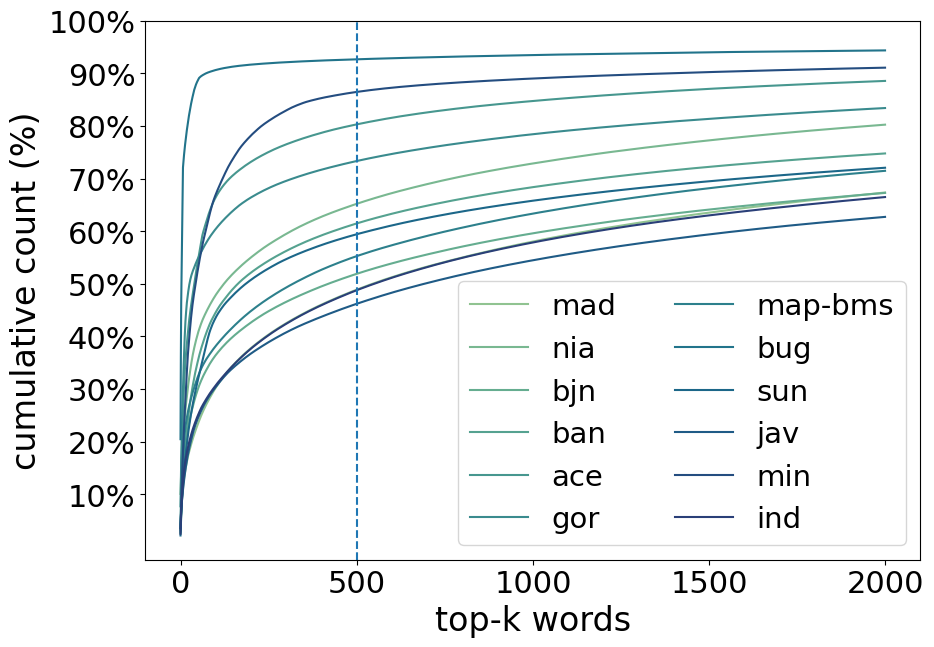

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

ax = sns.lineplot(wiki_df.loc[wiki_df['index'] < 2000,:], x='index', y='cum_count_norm', hue='lang', palette='crest')
ax.axvline(x = 500, ymin = 0, ymax = 1, linestyle='dashed')
plt.xticks([0, 500, 1000, 1500, 2000], [x * 500 for x in range(0,5)], fontsize=22)
plt.yticks(np.arange(0.1,1.01,0.1), [f'{x}0%' for x in range(1,11)], fontsize=22)
plt.legend(ncol=2, fontsize=21)
plt.xlabel('top-k words', fontsize=24)
plt.ylabel('cumulative count (%)', fontsize=24)
plt.savefig('cumulative_count_wiki.pdf', bbox_inches='tight')

In [92]:
import torch
torch.save(wiki_counters, 'wiki_counter.pt')

In [93]:
wiki_counters

71M	wiki_counter.pt


# Language Intersection

In [29]:
for lang in list(wiki_dsets.keys()):
    wiki_words = set()
    wiki_counter = {x: count for x, count in wiki_counters[lang].items() if count >= min_threshold}
    wiki_words = set(wiki_counter.keys())

    print('{} {} {}'.format(
        lang, 'ind',
        len(wiki_words.intersection(ind_words)) / len(wiki_words) if len(wiki_words) > 0 else 0,
    ))

    print('{} {} {}'.format(
        lang, 'eng',
        len(wiki_words.intersection(eng_words)) / len(wiki_words) if len(wiki_words) > 0 else 0,
    ))

bug ind 0.3896276595744681
bug eng 0.46808510638297873
mad ind 0.4735042735042735
mad eng 0.38564102564102565
jav ind 0.24015495430058714
jav eng 0.4406391864899219
min ind 0.2585409296687529
min eng 0.3445810553397818
sun ind 0.27986341102174317
sun eng 0.45362351634336495
map-bms ind 0.589933086986917
map-bms eng 0.3586337760910816
ace ind 0.38014689517026484
ace eng 0.39884264411306475
gor ind 0.5841438255231358
gor eng 0.40318302387267907
ban ind 0.311951891756452
ban eng 0.33625657729892255
bjn ind 0.49776999044281617
bjn eng 0.3861898693851545
nia ind 0.2763596004439512
nia eng 0.2672586015538291
ind ind 0.08504810881364878
ind eng 0.41789167611724903


In [30]:
# Using Count
for lang in list(wiki_dsets.keys()):
    wiki_word_cnt = sum(wiki_counters[lang].values())
    wiki_ind_cnt, wiki_eng_cnt = 0, 0
    for word in ind_words:
        wiki_ind_cnt += wiki_counters[lang][word]        
    for word in eng_words:
        wiki_eng_cnt += wiki_counters[lang][word]
        
    print('{} {} {}'.format(
        lang, 'ind',
        wiki_ind_cnt / wiki_word_cnt,
    ))

    print('{} {} {}'.format(
        lang, 'eng',
        wiki_eng_cnt / wiki_word_cnt,
    ))

bug ind 0.42948302646519954
bug eng 0.4898116993040607
mad ind 0.36554542094168657
mad eng 0.35467596431461484
jav ind 0.4451523597286574
jav eng 0.45681095408403133
min ind 0.5026578313991096
min eng 0.5501212942753257
sun ind 0.4365986958383808
sun eng 0.496654165609716
map-bms ind 0.6491613775901404
map-bms eng 0.5276360135716855
ace ind 0.3399132043762429
ace eng 0.46744954559075297
gor ind 0.6552359076897156
gor eng 0.6443427027045614
ban ind 0.44157139208671903
ban eng 0.4196112541135639
bjn ind 0.5673053242618874
bjn eng 0.5104576970554062
nia ind 0.3759875053713681
nia eng 0.43443212243413876
ind ind 0.8109267635784717
ind eng 0.5421973274475544


### Languge Intersection Word Level

In [12]:
%%time
# Load Lexicon Indonesia & English
if os.path.exists('ind_lexicon.zip') and os.path.exists('eng_lexicon.zip'):
    ind_lexicon = pd.read_pickle('ind_lexicon.zip')
    eng_lexicon = pd.read_pickle('eng_lexicon.zip')
else:
    langvar_df, expr_df, deno_df = load_panlex_resources('../resources/panlex-20230501-csv')
    
    ind_lexicon = extract_monolingual_lexicon('ind', langvar_df, expr_df)
    eng_lexicon = extract_monolingual_lexicon('eng', langvar_df, expr_df)
    
    ind_lexicon.to_pickle('ind_lexicon.zip')
    eng_lexicon.to_pickle('eng_lexicon.zip')

CPU times: user 248 ms, sys: 32.2 ms, total: 280 ms
Wall time: 805 ms


In [13]:
ind_words, eng_words = set(), set()
replacement_rules = str.maketrans('', '', string.punctuation + '0123456789')

for word in ind_lexicon['ind'].values:
    ind_words.add(word.lower().translate(replacement_rules))
for word in eng_lexicon['eng'].values:
    eng_words.add(word.lower().translate(replacement_rules))

##### Wikipedia

In [94]:
# Using Count
wiki_ind_counters = {}
wiki_eng_counters = {}
for lang in list(wiki_dsets.keys()):
    wiki_ind_counters[lang] = Counter()
    wiki_eng_counters[lang] = Counter()
    for word in ind_words:
        wiki_ind_counters[lang][word] = wiki_counters[lang][word]
    for word in eng_words:
        wiki_eng_counters[lang][word] = wiki_counters[lang][word]

In [102]:
for lang in list(wiki_dsets.keys()):    
    data = {'word':[], 'count':[]}
    for w, c in wiki_ind_counters[lang].most_common(200):
        data['word'].append(w)
        data['count'].append(c)
    pd.DataFrame(data).to_csv(f'./wiki_counts/{lang}_ind_200_count.csv', index=False)

In [103]:
for lang in list(wiki_dsets.keys()):    
    data = {'word':[], 'count':[]}
    for w, c in wiki_eng_counters[lang].most_common(200):
        data['word'].append(w)
        data['count'].append(c)
    pd.DataFrame(data).to_csv(f'./wiki_counts/{lang}_eng_200_count.csv', index=False)

##### Paragraph

In [14]:
# Using Count
para_ind_counters = {}
para_eng_counters = {}
for lang in list(paragraph_dsets.keys()):
    para_ind_counters[lang] = Counter()
    para_eng_counters[lang] = Counter()
    for word in ind_words:
        para_ind_counters[lang][word] = paragraph_counters[lang][word]
    for word in eng_words:
        para_eng_counters[lang][word] = paragraph_counters[lang][word]

In [16]:
dfs = []
for lang in list(paragraph_dsets.keys()):    
    data = {'lang':[], 'word':[], 'count':[]}
    for w, c in para_ind_counters[lang].most_common(200):
        data['word'].append(w)
        data['count'].append(c)
        data['lang'].append(lang)
    dfs.append(pd.DataFrame(data))
pd.concat(dfs).to_csv(f'./para_counts/ind_200_count.csv', index=False)

In [17]:
dfs = []
for lang in list(paragraph_dsets.keys()):    
    data = {'lang':[], 'word':[], 'count':[]}
    for w, c in para_eng_counters[lang].most_common(200):
        data['word'].append(w)
        data['count'].append(c)
        data['lang'].append(lang)
    dfs.append(pd.DataFrame(data))
pd.concat(dfs).to_csv(f'./para_counts/eng_200_count.csv', index=False)

##### Translation

In [18]:
# Using Count
mt_ind_counters = {}
mt_eng_counters = {}
for lang in list(mt_dsets.keys()):
    mt_ind_counters[lang] = Counter()
    mt_eng_counters[lang] = Counter()
    for word in ind_words:
        mt_ind_counters[lang][word] = mt_counters[lang][word]
    for word in eng_words:
        mt_eng_counters[lang][word] = mt_counters[lang][word]

In [19]:
dfs = []
for lang in list(mt_dsets.keys()):    
    data = {'lang':[], 'word':[], 'count':[]}
    for w, c in mt_ind_counters[lang].most_common(200):
        data['word'].append(w)
        data['count'].append(c)
        data['lang'].append(lang)
    dfs.append(pd.DataFrame(data))
pd.concat(dfs).to_csv(f'./mt_counts/ind_200_count.csv', index=False)

In [20]:
dfs = []
for lang in list(mt_dsets.keys()):    
    data = {'lang':[], 'word':[], 'count':[]}
    for w, c in mt_eng_counters[lang].most_common(200):
        data['word'].append(w)
        data['count'].append(c)
        data['lang'].append(lang)
    dfs.append(pd.DataFrame(data))
pd.concat(dfs).to_csv(f'./mt_counts/eng_200_count.csv', index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()
print(X.shape)

(4, 9)


In [233]:
words = [
    'indomie', 'angkot', 'rendang', 'tempe', 'tahu',
    'doa', 'ibadah', 'ojol', 'alay', 'gojek', 'jamu', 
    'gaib', 'santun', 'bule', 'alhamdulilah', 'insyaallah',
    'korupsi', 'gule', 'soto', 'sate'
]
wiki_data = {'word':[], 'bug':[], 'jav':[], 'mad':[], 'min':[], 'sun':[]}
para_data = {'word':[], 'bug':[], 'jav':[], 'mad':[], 'min':[], 'sun':[]}
mt_data = {'word':[], 'jav':[], 'mad':[], 'min':[], 'sun':[]}
for word in words:
    wiki_data['word'].append(word)
    para_data['word'].append(word)
    mt_data['word'].append(word)
    for lang in list(mt_dsets.keys()):
        wiki_data[lang].append(wiki_counters[lang][word])
        para_data[lang].append(paragraph_counters[lang][word])
        mt_data[lang].append(mt_counters[lang][word])

    for lang in ['bug']: 
        wiki_data[lang].append(wiki_counters[lang][word])
        para_data[lang].append(paragraph_counters[lang][word])

In [234]:
pd.DataFrame(wiki_data)

,word,bug,jav,mad,min,sun
0,indomie,0,36,1,1,51
1,angkot,0,14,0,8,56
2,rendang,0,36,0,14,24
3,tempe,0,123,0,29,11
4,tahu,0,708,5,125,187
5,doa,0,88,2,35,65
6,ibadah,0,124,4,159,263
7,ojol,0,0,0,0,0
8,alay,0,7,0,0,0
9,gojek,0,18,1,20,0


In [235]:
pd.DataFrame(para_data)

,word,bug,jav,mad,min,sun
0,indomie,0,24,9,12,15
1,angkot,8,52,3,57,254
2,rendang,7,27,9,4,32
3,tempe,2,101,45,29,31
4,tahu,32,117,87,127,128
5,doa,11,5,3,102,82
6,ibadah,33,195,32,139,240
7,ojol,0,6,0,0,16
8,alay,0,2,3,9,1
9,gojek,12,15,15,4,17


In [236]:
pd.DataFrame(mt_data)

,word,jav,mad,min,sun
0,indomie,9,7,11,11
1,angkot,6,4,6,5
2,rendang,3,3,0,3
3,tempe,3,2,2,3
4,tahu,28,6,26,6
5,doa,1,12,47,36
6,ibadah,12,2,15,16
7,ojol,5,4,6,5
8,alay,9,9,11,7
9,gojek,15,13,15,14


In [237]:
pd.DataFrame(wiki_data).to_csv('wiki_common.csv', index=False)

In [238]:
pd.DataFrame(para_data).to_csv('para_common.csv', index=False)

In [239]:
pd.DataFrame(mt_data).to_csv('mt_common.csv', index=False)

# Lexical Diversity

In [48]:
from lexicalrichness import LexicalRichness

for lang in ['jav', 'mad', 'bug', 'min', 'sun']:
    # Clean Text
    replacement_rules = str.maketrans('', '', string.punctuation + '0123456789')
    wiki_dsets[lang]['clean_text'] = wiki_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
    if lang in paragraph_dsets:
        paragraph_dsets[lang]['clean_text'] = paragraph_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
    if lang in mt_dsets:
        mt_dsets[lang]['clean_text'] = mt_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))

    print('Running On Wikipedia')
    mattrs, mtlds, maass, hdds, msttrs = [], [], [], [], []
    for i, text in enumerate(wiki_dsets[lang]['clean_text']):
        lex = LexicalRichness(text)
        if len(list(filter(lambda x: len(x) > 1, text.strip().split(' ')))) >= 25:
            mattrs.append(lex.mattr(window_size=20))
            mtlds.append(lex.mtld(threshold=0.72))
            maass.append(lex.Maas)
            hdds.append(lex.hdd(draws=20))
            # vocds.append(lex.vocd(ntokens=50, within_sample=100, iterations=3))
            msttrs.append(lex.msttr(segment_window=20))
        else:
            mattrs.append(np.nan)
            mtlds.append(np.nan)
            maass.append(np.nan)
            hdds.append(np.nan)
            msttrs.append(np.nan)
    wiki_dsets[lang]['mattr'] = mattrs
    wiki_dsets[lang]['mtld'] = mtlds
    wiki_dsets[lang]['maas'] = maass
    wiki_dsets[lang]['hdd'] = hdds
    wiki_dsets[lang]['msttr'] = msttrs
        
    if lang != 'jav':
        print('Running On Paragraph')
        if lang in paragraph_dsets:
            mattrs, mtlds, maass, hdds, msttrs = [], [], [], [], []
            for i, text in enumerate(paragraph_dsets[lang]['clean_text']):
                lex = LexicalRichness(text)
                if len(list(filter(lambda x: len(x) > 1, text.strip().split(' ')))) >= 25:
                    mattrs.append(lex.mattr(window_size=20))
                    mtlds.append(lex.mtld(threshold=0.72))
                    maass.append(lex.Maas)
                    hdds.append(lex.hdd(draws=20))
                    msttrs.append(lex.msttr(segment_window=20))
                else:
                    mattrs.append(np.nan)
                    mtlds.append(np.nan)
                    maass.append(np.nan)
                    hdds.append(np.nan)
                    msttrs.append(np.nan)
            paragraph_dsets[lang]['mattr'] = mattrs
            paragraph_dsets[lang]['mtld'] = mtlds
            paragraph_dsets[lang]['maas'] = maass
            paragraph_dsets[lang]['hdd'] = hdds
            paragraph_dsets[lang]['msttr'] = msttrs

        print('Running On MT')
        if lang in mt_dsets:
            mattrs, mtlds, maass, hdds, msttrs = [], [], [], [], []
            for i, text in enumerate(mt_dsets[lang]['clean_text']):
                lex = LexicalRichness(text)
                if len(list(filter(lambda x: len(x) > 1, text.strip().split(' ')))) >= 25:
                    mattrs.append(lex.mattr(window_size=20))
                    mtlds.append(lex.mtld(threshold=0.72))
                    maass.append(lex.Maas)
                    hdds.append(lex.hdd(draws=20))
                    msttrs.append(lex.msttr(segment_window=20))
                else:
                    mattrs.append(np.nan)
                    mtlds.append(np.nan)
                    maass.append(np.nan)
                    hdds.append(np.nan)
                    msttrs.append(np.nan)
            mt_dsets[lang]['mattr'] = mattrs
            mt_dsets[lang]['mtld'] = mtlds
            mt_dsets[lang]['maas'] = maass
            mt_dsets[lang]['hdd'] = hdds
            mt_dsets[lang]['msttr'] = msttrs
    
#     wiki_dsets[lang][['text', 'mattr', 'mtld', 'maas']].to_csv(f'diversity/wiki_{lang}.csv')
#     if lang in paragraph_dsets:
#         paragraph_dsets[lang][['text', 'mattr', 'mtld', 'maas']].to_csv(f'diversity/para_{lang}.csv')
#     if lang in mt_dsets:
#         mt_dsets[lang][['text', 'mattr', 'mtld', 'maas']].to_csv(f'diversity/mt_{lang}.csv')
    
    print(f'== {lang} ==')
    print(f'WIKI: {wiki_dsets[lang]["mattr"].mean()} {wiki_dsets[lang]["mtld"].mean()} {wiki_dsets[lang]["maas"].mean()} {wiki_dsets[lang]["hdd"].mean()} {wiki_dsets[lang]["msttr"].mean()}')
    if lang in paragraph_dsets:
        print(f'PARA: {paragraph_dsets[lang]["mattr"].mean()} {paragraph_dsets[lang]["mtld"].mean()} {paragraph_dsets[lang]["maas"].mean()} {paragraph_dsets[lang]["hdd"].mean()} {paragraph_dsets[lang]["msttr"].mean()}')
    if lang in mt_dsets:
        print(f'MT: {mt_dsets[lang]["mattr"].mean()} {mt_dsets[lang]["mtld"].mean()} {mt_dsets[lang]["maas"].mean()} {mt_dsets[lang]["hdd"].mean()} {mt_dsets[lang]["msttr"].mean()}')
        

Running On Wikipedia
== jav ==
WIKI: 0.8770643948054657 68.1535211554773 0.018800924337848423 0.8818755553851829 0.8798791771630815
PARA: 0.8893802893316376 62.550863690913225 0.021392573223002996 0.8794541265391201 0.887571201987059
MT: 0.9153986876852744 92.18846804381735 0.011737639116165089 0.9155835205906315 0.913349573395385
Running On Wikipedia
Running On Paragraph
Running On MT
== mad ==
WIKI: 0.8867065172883336 89.46325483913797 0.01461384815239539 0.9053390097531582 0.8851669432447673
PARA: 0.9077131181144935 78.25656188698593 0.018553149951451076 0.900285721030389 0.9063579485398714
MT: 0.9113144673306145 88.60186707467294 0.012359094916752864 0.9112207169901037 0.91011012252042
Running On Wikipedia
Running On Paragraph
Running On MT
== bug ==
WIKI: 0.8025172093314292 51.02237303259746 0.02666852624042112 0.8073381572675332 0.8232195875373821
PARA: 0.90198554467218 82.78228985188375 0.017448242734691838 0.8963594027872709 0.8999351785714286
Running On Wikipedia
Running On Pa

In [49]:
for lang in ['bug', 'mad', 'jav', 'min', 'sun']:
    print(f'== {lang} ==')
    print(f'WIKI: {wiki_dsets[lang]["mattr"].mean()} {wiki_dsets[lang]["mtld"].mean()} {wiki_dsets[lang]["maas"].mean()} {wiki_dsets[lang]["hdd"].mean()} {wiki_dsets[lang]["msttr"].mean()}')
    if lang in paragraph_dsets:
        print(f'PARA: {paragraph_dsets[lang]["mattr"].mean()} {paragraph_dsets[lang]["mtld"].mean()} {paragraph_dsets[lang]["maas"].mean()} {paragraph_dsets[lang]["hdd"].mean()} {paragraph_dsets[lang]["msttr"].mean()}')
    if lang in mt_dsets:
        print(f'MT: {mt_dsets[lang]["mattr"].mean()} {mt_dsets[lang]["mtld"].mean()} {mt_dsets[lang]["maas"].mean()} {mt_dsets[lang]["hdd"].mean()} {mt_dsets[lang]["msttr"].mean()}')

== bug ==
WIKI: 0.8025172093314292 51.02237303259746 0.02666852624042112 0.8073381572675332 0.8232195875373821
PARA: 0.90198554467218 82.78228985188375 0.017448242734691838 0.8963594027872709 0.8999351785714286
== mad ==
WIKI: 0.8867065172883336 89.46325483913797 0.01461384815239539 0.9053390097531582 0.8851669432447673
PARA: 0.9077131181144935 78.25656188698593 0.018553149951451076 0.900285721030389 0.9063579485398714
MT: 0.9113144673306145 88.60186707467294 0.012359094916752864 0.9112207169901037 0.91011012252042
== jav ==
WIKI: 0.8770643948054657 68.1535211554773 0.018800924337848423 0.8818755553851829 0.8798791771630815
PARA: 0.8893802893316376 62.550863690913225 0.021392573223002996 0.8794541265391201 0.887571201987059
MT: 0.9153986876852744 92.18846804381735 0.011737639116165089 0.9155835205906315 0.913349573395385
== min ==
WIKI: 0.9346951572627828 89.5601696092024 0.011843944243683359 0.9211582735675593 0.9231144221384834
PARA: 0.9063460590367063 78.58110590660242 0.01838325062

In [50]:
for lang in ['bug', 'mad', 'jav', 'min', 'sun']:
    print(f'== {lang} ==')
    print(f'WIKI: {wiki_dsets[lang]["mattr"].median()} {wiki_dsets[lang]["mtld"].median()} {wiki_dsets[lang]["maas"].median()} {wiki_dsets[lang]["hdd"].median()} {wiki_dsets[lang]["msttr"].median()}')
    if lang in paragraph_dsets:
        print(f'PARA: {paragraph_dsets[lang]["mattr"].median()} {paragraph_dsets[lang]["mtld"].median()} {paragraph_dsets[lang]["maas"].median()} {paragraph_dsets[lang]["hdd"].median()} {paragraph_dsets[lang]["msttr"].median()}')
    if lang in mt_dsets:
        print(f'MT: {mt_dsets[lang]["mattr"].median()} {mt_dsets[lang]["mtld"].median()} {mt_dsets[lang]["maas"].median()} {mt_dsets[lang]["hdd"].median()} {mt_dsets[lang]["msttr"].median()}')

== bug ==
WIKI: 0.798076923076923 28.60677612538577 0.026552829810731517 0.801241125596174 0.85
PARA: 0.9051178524661724 75.99401102524992 0.01731726241365138 0.8987034675079688 0.9
== mad ==
WIKI: 0.8988140161725064 67.20860273523544 0.014337578918395131 0.9105786982309678 0.9
PARA: 0.9112244897959195 73.29579525503084 0.0183536821752621 0.9029199023029529 0.9099999999999999
MT: 0.9222222222222223 71.48752709577528 0.011117123943966505 0.9217503217503209 0.925
== jav ==
WIKI: 0.8917724203089938 58.936399932042136 0.017942453849145175 0.8974366571235914 0.8926198257080609
PARA: 0.8933734939759037 58.154803379203855 0.02105534115542086 0.8839220409108955 0.89
MT: 0.9262531328320802 72.57600000000004 0.010843046712604575 0.9246031746031743 0.925
== min ==
WIKI: 0.9423076923076922 80.86400000000003 0.011127399755762301 0.9242495309568486 0.925
PARA: 0.9095916666666675 73.36580305173143 0.01818511374491436 0.9024878767852461 0.9099999999999999
MT: 0.9215838509316774 68.72444444444443 0.011

In [ ]:
from lexicalrichness import LexicalRichness

for lang in list(wiki_dsets.keys()):
    # Clean Text
    replacement_rules = str.maketrans('', '', string.punctuation + '0123456789')
    wiki_dsets[lang]['clean_text'] = wiki_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
    if lang in paragraph_dsets:
        paragraph_dsets[lang]['clean_text'] = paragraph_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))
    if lang in mt_dsets:
        mt_dsets[lang]['clean_text'] = mt_dsets[lang]['text'].apply(lambda x: x.lower().translate(replacement_rules).replace('\n',' '))

    mattrs, mtlds, maass, hdds, msttrs = [], [], [], [], []
    for i, text in enumerate(wiki_dsets[lang]['clean_text']):
        lex = LexicalRichness(text)
        if len(list(filter(lambda x: len(x) > 1, text.strip().split(' ')))) >= 25:
            mattrs.append(lex.mattr(window_size=20))
            mtlds.append(lex.mtld(threshold=0.72))
            maass.append(lex.Maas)
            hdds.append(lex.hdd(draws=20))
            # vocds.append(lex.vocd(ntokens=25, within_sample=100, iterations=3))
            msttrs.append(lex.msttr(segment_window=20))
        else:
            mattrs.append(np.nan)
            mtlds.append(np.nan)
            maass.append(np.nan)
            hdds.append(np.nan)
            msttrs.append(np.nan)
    wiki_dsets[lang]['mattr'] = mattrs
    wiki_dsets[lang]['mtld'] = mtlds
    wiki_dsets[lang]['maas'] = maass
    wiki_dsets[lang]['hdd'] = hdds
    wiki_dsets[lang]['msttr'] = msttrs
    
    print(f'== {lang} ==')
    print(f'WIKI: {wiki_dsets[lang]["mattr"].mean()} {wiki_dsets[lang]["mtld"].mean()} {wiki_dsets[lang]["maas"].mean()} {wiki_dsets[lang]["hdd"].mean()} {wiki_dsets[lang]["msttr"].mean()}')

== bug ==
WIKI: 0.8025172093314292 51.02237303259746 0.02666852624042112 0.8073381572675332 0.8232195875373821
== mad ==
WIKI: 0.8867065172883336 89.46325483913797 0.01461384815239539 0.9053390097531582 0.8851669432447673
== jav ==
WIKI: 0.8770643948054657 68.1535211554773 0.018800924337848423 0.8818755553851829 0.8798791771630815
== min ==
WIKI: 0.9346951572627828 89.5601696092024 0.011843944243683359 0.9211582735675593 0.9231144221384834
== sun ==
WIKI: 0.9113387836041631 74.85608594348213 0.01684790543462043 0.8892273829602992 0.9022421833377625
== map-bms ==
WIKI: 0.8661854005731374 70.76320693550588 0.019062702037850775 0.8789127996416582 0.8617453113836908
== ace ==
WIKI: 0.7787468003710114 30.653040031302027 0.03446295026505121 0.7591176274019195 0.8017896065652931


In [58]:
from lexicalrichness import LexicalRichness

for lang in list(wiki_dsets.keys()):
    print(f'{lang} WIKI {len(wiki_dsets[lang])} {wiki_dsets[lang]["mattr"].mean()} {wiki_dsets[lang]["mtld"].mean()} {wiki_dsets[lang]["maas"].mean()} {wiki_dsets[lang]["hdd"].mean()} {wiki_dsets[lang]["msttr"].mean()}')

bug WIKI 15866 0.8025172093314292 51.02237303259746 0.02666852624042112 0.8073381572675332 0.8232195875373821
mad WIKI 1002 0.8867065172883336 89.46325483913797 0.01461384815239539 0.9053390097531582 0.8851669432447673
jav WIKI 72737 0.8770643948054657 68.1535211554773 0.018800924337848423 0.8818755553851829 0.8798791771630815
min WIKI 226237 0.9346951572627828 89.5601696092024 0.011843944243683359 0.9211582735675593 0.9231144221384834
sun WIKI 61331 0.9113387836041631 74.85608594348213 0.01684790543462043 0.8892273829602992 0.9022421833377625
map-bms WIKI 13575 0.8661854005731374 70.76320693550588 0.019062702037850775 0.8789127996416582 0.8617453113836908
ace WIKI 12829 0.7787468003710114 30.653040031302027 0.03446295026505121 0.7591176274019195 0.8017896065652931
gor WIKI 14389 0.6940185419158188 37.225365925589436 0.042645348260039385 0.7135722061881534 0.8202527344064151
ban WIKI 17161 0.8515263409214967 53.8335470548051 0.021629884329270658 0.865722282832719 0.8650753408056899
bjn